# Histopathologic Cancer Detection

Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import os
from tqdm import tqdm
import cv2

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

drive.mount('/content/drive')

Mounted at /content/drive


## Brief description of the problem and data (5 pts)
The goal of this project is to build a binary classification model that identifies the presence of metastatic cancer in small image patches (96×96 pixels) extracted from larger digital pathology scans of lymph node tissue in breast cancer patients.

### Dataest
- 96×96 pixel RGB images
- Each image is labeled with either 0 or 1, indicating whether **the central 32×32 pixel region** contains tumor tissue (1) or not (0).
- The training dataset includes labels, while the test dataset is unlabeled and requires probability predictions for submission.

### Task
- Objective: Train a classifier to detect the presence of tumor (metastatic cancer) in each image patch.
- Output: Predict a probability score (between 0.0 and 1.0) indicating the likelihood of tumor presence for each test image.

### Evaluation Metric
The evaluation metric is ROC-AUC, which measures how well the model distinguishes between cancerous and non-cancerous patches

In [ ]:
# The dataset is so large that causes a too-many-files problem in Google Drive
# so I need to unzip every time.

!mkdir data
!cp '/content/drive/My Drive/Education/CU/ML3/Week3/histopathologic-cancer-detection.zip' .
!unzip -n -q ./histopathologic-cancer-detection.zip -d ./data

TRAIN_DIR = './data/train/'
TEST_DIR = './data/test/'
LABELS_PATH = './data/train_labels.csv'

labels_df = pd.read_csv(LABELS_PATH)
labels_df.set_index('id', inplace=True)

In [ ]:
!ls ./data/train | wc -l

220025


In [ ]:
!ls ./data/test | wc -l

57458


Each image in the dataset has a resolution of 96x96 pixels. The training set consists of 220,025 samples, and the test set contains 57,458 samples. The total dataset size is approximately 7GB. Although it is not impossible to load the entire dataset into memory at once, doing so would be inefficient. Therefore, it is more practical to load the data on demand during training. For the initial exploratory data analysis (EDA), I loaded a subset of the images into memory.

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

### labels
No obvious class imbalance was observed.

Label counts:
 label
0    130908
1     89117
Name: count, dtype: int64

Label ratio:
 label
0    0.594969
1    0.405031
Name: count, dtype: float64


<ipython-input-5-6a15dd0262c9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=labels_df, x='label', palette='Set2')


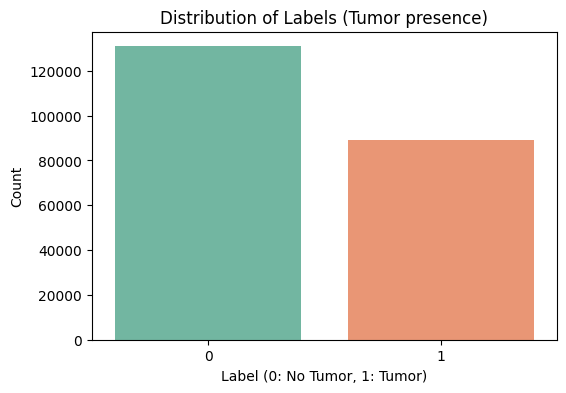

In [ ]:


label_counts = labels_df['label'].value_counts()
print("Label counts:\n", label_counts)
print("\nLabel ratio:\n", label_counts / len(labels_df))

plt.figure(figsize=(6, 4))
sns.countplot(data=labels_df, x='label', palette='Set2')
plt.title("Distribution of Labels (Tumor presence)")
plt.xlabel("Label (0: No Tumor, 1: Tumor)")
plt.ylabel("Count")
plt.show()

### image

100%|██████████| 10/10 [00:00<00:00, 221.14it/s]


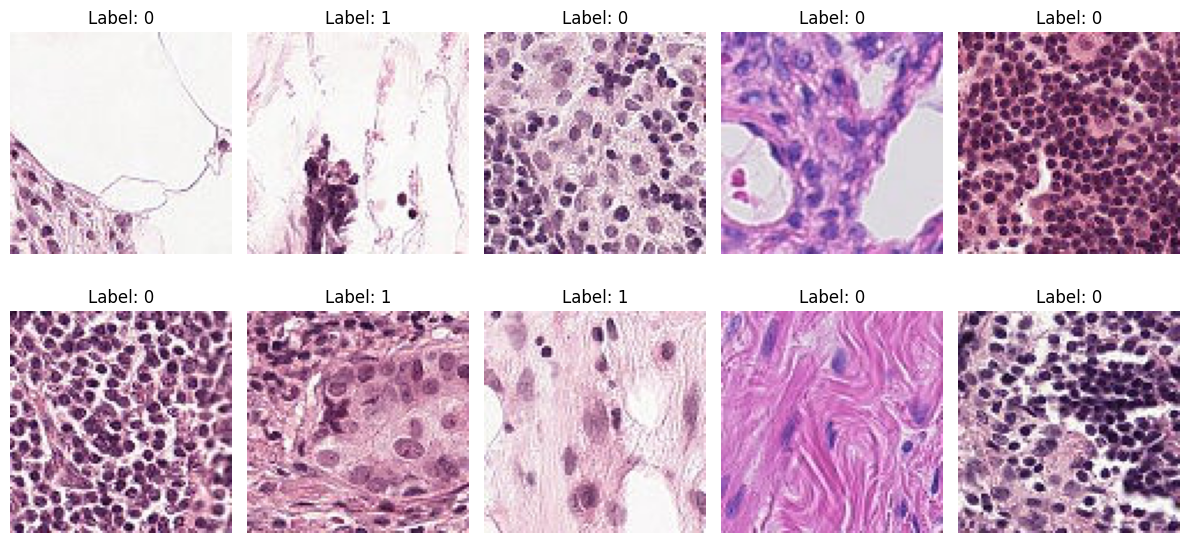

In [ ]:
IMG_SIZE = 96

def load_images_cv2(image_ids, directory, img_size=IMG_SIZE):
    images = []
    for image_id in tqdm(image_ids):
        image_path = os.path.join(directory, image_id + '.tif')
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_size, img_size))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    return np.array(images)

# Visualize first 10 train samples
train_ids_sample = labels_df.index[:10].tolist()
X_train_sample = load_images_cv2(train_ids_sample, TRAIN_DIR)
y_train_sample = labels_df.loc[train_ids_sample, 'label'].values

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_sample[i])
    plt.title(f"Label: {y_train_sample[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


- In images labeled as 1 (positive), cells showing nuclear atypia can often be observed near the center of the patch.  
- There is noticeable diversity in image brightness.  
- The magnification levels also appear to vary across samples.  
- Additionally, there does not seem to be any orientation-specific information in the images; for example, unlike chest X-rays—where flipping the image vertically would change its clinical meaning—such issues do not appear to apply in this dataset.  
- Therefore, data augmentation techniques such as brightness adjustment, scaling, horizontal flipping, and vertical flipping are likely to be effective.

From a pathological standpoint, the observed features are relatively common findings across various primary sites and tissue types. Training the model to recognize these general patterns will likely be key to improving performance.


### train-valid split

In [ ]:
from sklearn.model_selection import train_test_split

labels_df['filepath'] = TRAIN_DIR + labels_df.index + '.tif'

train_df, valid_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['label'],
    random_state=42
)

print("Train size:", len(train_df))
print("Valid size:", len(valid_df))

Train size: 176020
Valid size: 44005


In [ ]:
test_ids = [fname[:-4] for fname in os.listdir(TEST_DIR) if fname.endswith('.tif')]
test_df = pd.DataFrame({'id': test_ids})
test_df['filepath'] = TEST_DIR + test_df['id'] + '.tif'

## Model Architecture (25 pts)

Before building a CNN model for this task, I would like to demonstrate my understanding by briefly explaining a few key concepts in my own words:

- **Convolutional Neural Network (CNN)**: A deep learning model designed to extract local spatial features from images, widely used for image classification and pattern recognition.
- **ImageNet**: A large-scale dataset containing millions of labeled images, commonly used for training and benchmarking deep learning models in computer vision.
- **Inception V3**: A high-performing and computationally efficient CNN architecture developed by Google, known for its use in image classification challenges.
- **Global Average Pooling**: A dimensionality reduction technique that converts each feature map into a single value by taking the average of all its spatial values.
- **Fine-tuning**: A technique where a pretrained model is adapted to a new task by retraining some of its layers, typically the later ones, to better fit the target data.

### Experimental Setup

Histopathological images differ significantly from the natural images found in datasets like ImageNet. Therefore, it is uncertain whether using pretrained weights from ImageNet would be effective for this task. To investigate this, I conducted experiments using both pretrained weights and randomly initialized weights. Additionally, I tested a configuration where only the final layer was trained while keeping the rest of the pretrained model frozen.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=45,
    brightness_range=[0.8, 1.2],
    zoom_range=[1, 1.5],
    # Since the positive samples are supposed to have the tumor cells in the central part,
    # the cells remain within the FOV after zooming to this degree.
)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(96, 96),
    batch_size=1024,
    class_mode='raw',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='filepath',
    y_col='label',
    target_size=(96, 96),
    batch_size=128,
    class_mode='raw',
    shuffle=False
)


Found 176020 validated image filenames.
Found 44005 validated image filenames.


In [ ]:
test_generator = valid_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col=None,
    target_size=(96, 96),
    batch_size=128,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Crossentropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def generate_submission_file(model, name):
    print(f"Predicting with model: {name}")
    test_pred_probs = model.predict(test_generator, verbose=1).flatten()
    test_pred_binary = (test_pred_probs > 0.5).astype(int)

    submission_df = pd.DataFrame({
        'id': test_df['id'],
        'label': test_pred_binary
    })

    filename = f'/content/drive/My Drive/Education/CU/ML3/Week3/{name}_submission.csv'
    submission_df.to_csv(filename, index=False)
    print(f"Saved submission to: {filename}")

In [ ]:
base_model = InceptionV3(weights=None, include_top=False, input_shape=(96, 96, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    start_from_epoch=3,
    restore_best_weights=True,
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=[early_stop],
    # for debugging
    # epochs=3,
    # steps_per_epoch=10,
    # validation_steps=2,
)


Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 714s 4s/step - accuracy: 0.7814 - loss: 0.4824 - val_accuracy: 0.5615 - val_loss: 0.8477
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - accuracy: 0.8553 - loss: 0.3372 - val_accuracy: 0.5420 - val_loss: 2.2242
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.8777 - loss: 0.2951 - val_accuracy: 0.7358 - val_loss: 1.0454
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.8921 - loss: 0.2653 - val_accuracy: 0.7643 - val_loss: 0.8909
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.8986 - loss: 0.2461 - val_accuracy: 0.8815 - val_loss: 0.3431
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.9068 - loss: 0.2293 - val_accuracy: 0.8831 - val_loss: 0.3214
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.9124 - loss: 0.2196 - val_accuracy: 0.8229 - val_loss: 0.5492
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.9190 - loss: 0.2065 - val_accu

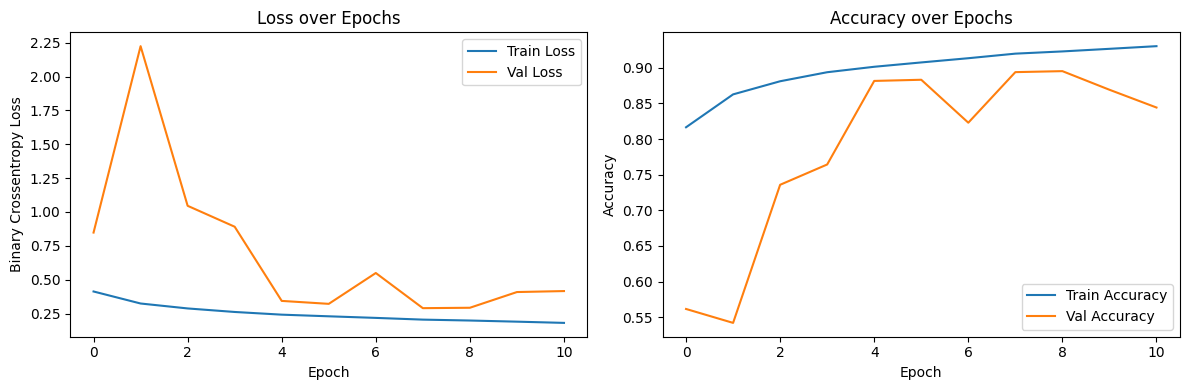

344/344 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step
Predicting with model: scratch


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step
Saved submission to: /content/drive/My Drive/Education/CU/ML3/Week3/scratch_submission.csv


In [ ]:
plot_training_history(history)

y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred_label = (y_pred_prob > 0.5).astype(int).flatten()

valid_df['scratch_pred'] = y_pred_prob.flatten()
valid_df['scratch_pred_binary'] = y_pred_label

generate_submission_file(model, 'scratch')

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    start_from_epoch=3,
    restore_best_weights=True,
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    # batch_size=32,
    callbacks=[early_stop],
    # for debugging
    # epochs=3,
    # steps_per_epoch=10,
    # validation_steps=2,
)

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 598s 3s/step - accuracy: 0.6861 - loss: 0.6765 - val_accuracy: 0.7651 - val_loss: 0.4939
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.7743 - loss: 0.4791 - val_accuracy: 0.7751 - val_loss: 0.4716
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.7822 - loss: 0.4658 - val_accuracy: 0.7880 - val_loss: 0.4575
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.7843 - loss: 0.4633 - val_accuracy: 0.7937 - val_loss: 0.4547
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.7882 - loss: 0.4573 - val_accuracy: 0.7896 - val_loss: 0.4501
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.7893 - loss: 0.4547 - val_accuracy: 0.7870 - val_loss: 0.4496
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.7943 - loss: 0.4489 - val_accuracy: 0.8022 - val_loss: 0.4370
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 584s 3s/step - accuracy: 0.7921 - loss: 0.4488 - val_accu

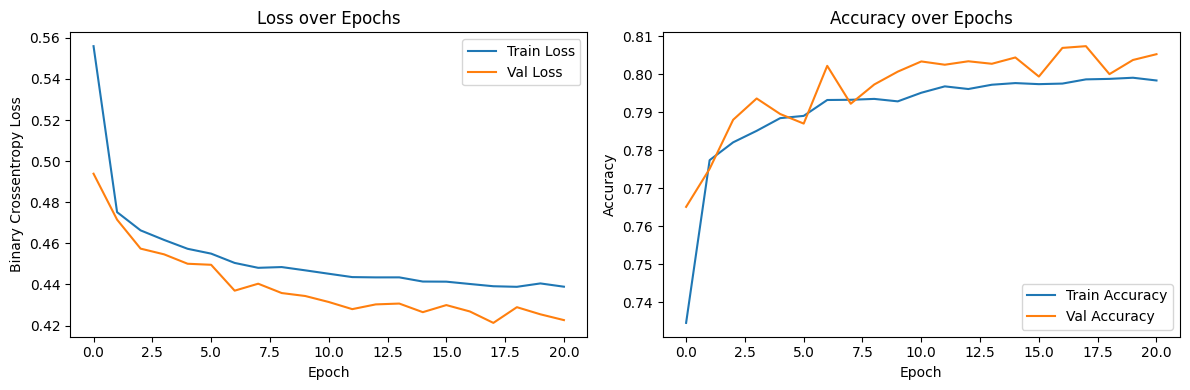

344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step
Predicting with model: imagenet_head
449/449 ━━━━━━━━━━━━━━━━━━━━ 45s 88ms/step
Saved submission to: /content/drive/My Drive/Education/CU/ML3/Week3/imagenet_head_submission.csv


In [ ]:
plot_training_history(history)

y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred_label = (y_pred_prob > 0.5).astype(int).flatten()

valid_df['imagenet_head_pred'] = y_pred_prob.flatten()
valid_df['imagenet_head_pred_binary'] = y_pred_label

generate_submission_file(model, 'imagenet_head')

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    start_from_epoch=3,
    restore_best_weights=True,
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    # batch_size=32,
    callbacks=[early_stop],
    # for debugging
    # epochs=3,
    # steps_per_epoch=10,
    # validation_steps=2,
)

Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 681s 4s/step - accuracy: 0.7606 - loss: 0.4717 - val_accuracy: 0.8623 - val_loss: 0.3497
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.8999 - loss: 0.2467 - val_accuracy: 0.9020 - val_loss: 0.2490
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.9220 - loss: 0.2018 - val_accuracy: 0.9179 - val_loss: 0.2099
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 583s 3s/step - accuracy: 0.9326 - loss: 0.1781 - val_accuracy: 0.9111 - val_loss: 0.2352
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.9390 - loss: 0.1612 - val_accuracy: 0.9240 - val_loss: 0.2027
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - accuracy: 0.9440 - loss: 0.1491 - val_accuracy: 0.9111 - val_loss: 0.2467
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.9468 - loss: 0.1409 - val_accuracy: 0.9389 - val_loss: 0.1725
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.9507 - loss: 0.1318 - val_accu

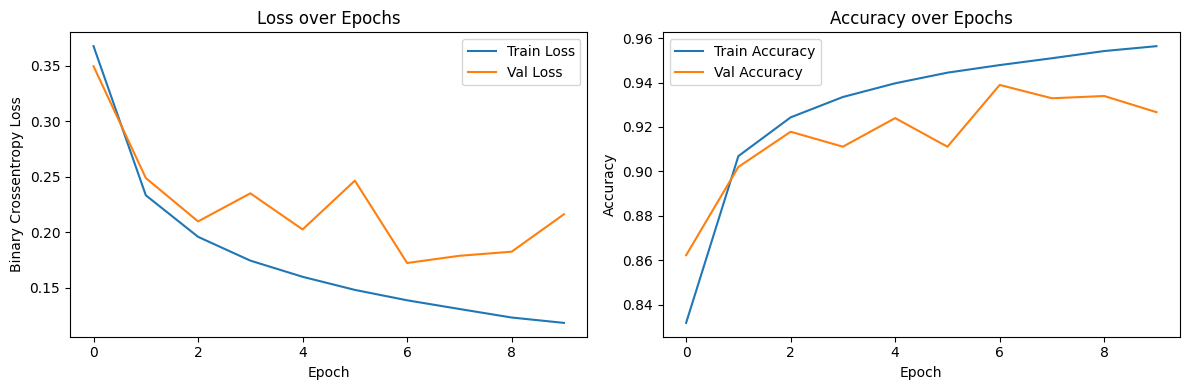

344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step
Predicting with model: imagenet_all
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step
Saved submission to: /content/drive/My Drive/Education/CU/ML3/Week3/imagenet_all_submission.csv


In [ ]:
plot_training_history(history)

y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred_label = (y_pred_prob > 0.5).astype(int).flatten()

valid_df['imagenet_all_pred'] = y_pred_prob.flatten()
valid_df['imagenet_all_pred_binary'] = y_pred_label

generate_submission_file(model, 'imagenet_all')

## Results and Analysis (35 pts)

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

def evaluate_model(y_true, y_prob, y_pred, model_name='Model'):
    print(f"\n{model_name} - Evaluation Metrics")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()



InceptionV3 (Scratch) - Evaluation Metrics
Accuracy : 0.8938
Precision: 0.8419
Recall   : 0.9085
F1 Score : 0.8739

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.88      0.91     26182
           1       0.84      0.91      0.87     17823

    accuracy                           0.89     44005
   macro avg       0.89      0.90      0.89     44005
weighted avg       0.90      0.89      0.89     44005



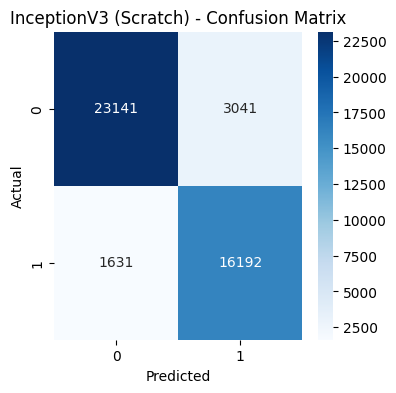

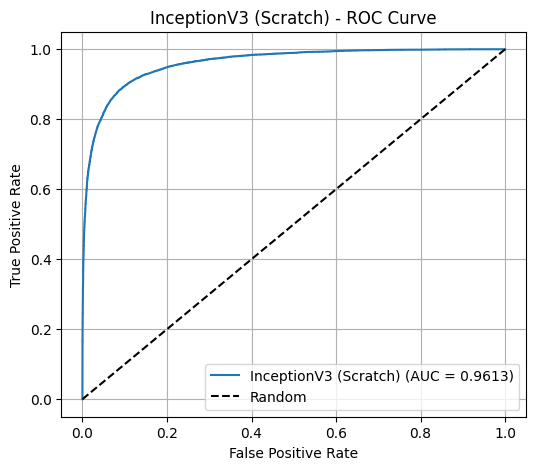


InceptionV3 (ImageNet, head-only trainable) - Evaluation Metrics
Accuracy : 0.8074
Precision: 0.8336
Recall   : 0.6554
F1 Score : 0.7338

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.91      0.85     26182
           1       0.83      0.66      0.73     17823

    accuracy                           0.81     44005
   macro avg       0.81      0.78      0.79     44005
weighted avg       0.81      0.81      0.80     44005



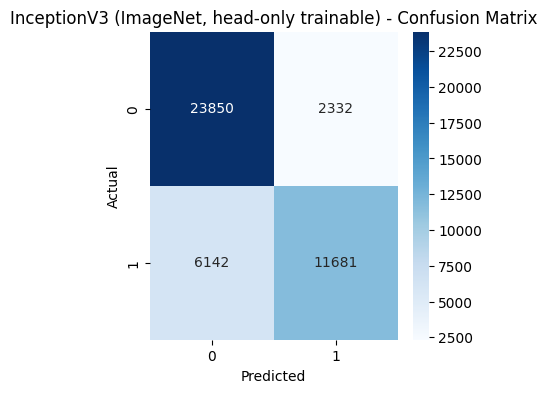

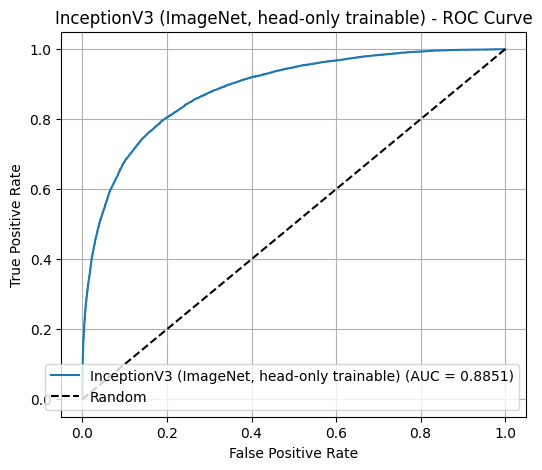


InceptionV3 (ImageNet, all trainable) - Evaluation Metrics
Accuracy : 0.9389
Precision: 0.9560
Recall   : 0.8901
F1 Score : 0.9219

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     26182
           1       0.96      0.89      0.92     17823

    accuracy                           0.94     44005
   macro avg       0.94      0.93      0.94     44005
weighted avg       0.94      0.94      0.94     44005



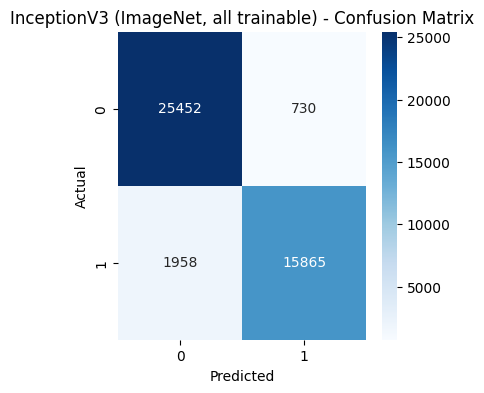

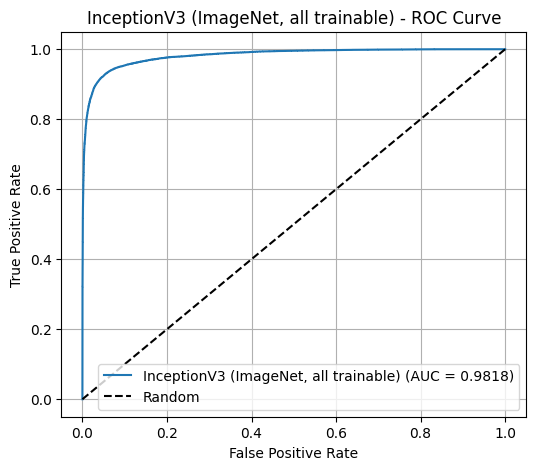

In [ ]:
y_true = valid_df['label'].values

evaluate_model(
    y_true=y_true,
    y_prob=valid_df['scratch_pred'].values,
    y_pred=valid_df['scratch_pred_binary'].values,
    model_name='InceptionV3 (Scratch)'
)

evaluate_model(
    y_true=y_true,
    y_prob=valid_df['imagenet_head_pred'].values,
    y_pred=valid_df['imagenet_head_pred_binary'].values,
    model_name='InceptionV3 (ImageNet, head-only trainable)'
)

evaluate_model(
    y_true=y_true,
    y_prob=valid_df['imagenet_all_pred'].values,
    y_pred=valid_df['imagenet_all_pred_binary'].values,
    model_name='InceptionV3 (ImageNet, all trainable)'
)

In [ ]:
def show_misclassified_images(df, pred_col, true_col='label', title='Misclassified Samples', num_images=8):
    misclassified = df[df[pred_col] != df[true_col]]
    print(f"Misclassified samples: {len(misclassified)}")

    if len(misclassified) == 0:
        print("All predictions are correct!")
        return

    sample = misclassified.sample(n=min(num_images, len(misclassified)), random_state=42)

    plt.figure(figsize=(16, 4))
    for i, (_, row) in enumerate(sample.iterrows()):
        img = cv2.imread(row['filepath'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"True: {row[true_col]} | Pred: {row[pred_col]}")
        plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


Misclassified samples: 2688


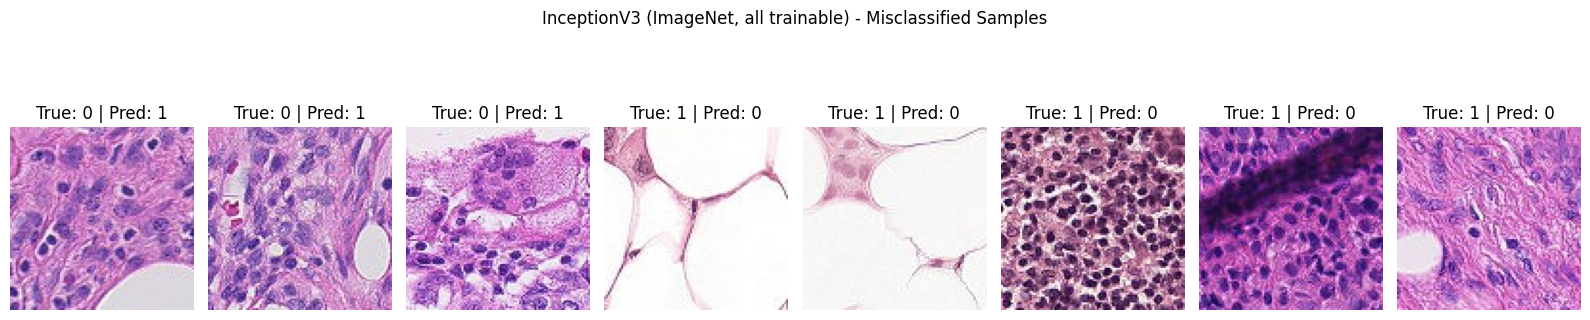

In [ ]:
show_misclassified_images(
    df=valid_df,
    pred_col='imagenet_all_pred_binary',
    title='InceptionV3 (ImageNet, all trainable) - Misclassified Samples'
)


### Summary of results and analysis

| Model                                            | Val Accuracy | Val Precision | Val Recall | Val F1 Score | Test Public Score | Test Private Score |
|--------------------------------------------------|-------------:|--------------:|-----------:|-------------:|------------------:|-------------------:|
| **InceptionV3 (Scratch)**                        | 0.8938       | 0.8419        | 0.9085     | 0.8739       | 0.8205            | 0.8489            |
| **InceptionV3 (ImageNet, head-only)**            | 0.8074       | 0.8336        | 0.6554     | 0.7338       | 0.7373            | 0.7806            |
| **InceptionV3 (ImageNet, all trainable)**        | 0.9389       | 0.9560        | 0.8901     | 0.9219       | 0.8354            | 0.8521            |


- The best-performing model was the one in which all layers were fine-tuned using pretrained weights from ImageNet.

- However, training the model without pretrained weights resulted in only a slightly lower performance. This may be attributed to the relatively large number of samples in the dataset, which likely enabled the model to learn fundamental visual perception capabilities without relying on ImageNet features.

- In contrast, using ImageNet-InceptionV3 as a **feature extractor** (i.e., freezing all layers except the final few) resulted in a significantly lower accuracy. This suggests a substantial domain gap between natural images in ImageNet and pathology images, leading to ineffective feature extraction for histopathological diagnosis.

- These results highlight the importance of considering both the **number of available samples** and the **domain distance** of the dataset when deciding on fine-tuning strategies. In cases like this, where a large number of samples is available despite a substantial domain gap, increasing the number of trainable parameters (i.e., full fine-tuning) appears to be more effective.

- Regarding misclassified examples:
  - Some **false positives** contained ambiguous cells that resembled nuclear atypia, which could easily confuse even experienced clinicians.
  - Some **false negatives** showed structures resembling adipose tissue around lymph nodes, which may have masked tumor presence.
  - Given the limited field of view and visual context in each image patch, many of these misclassified samples would be challenging even for non-specialist physicians. They can be considered high-difficulty cases.


## Conclusion (15 pts)

In this project, we applied deep learning techniques to the classification of histopathological images, focusing particularly on evaluating and comparing various fine-tuning strategies. Through these experiments, we explored when and how fine-tuning can be most effectively utilized in medical image classification tasks.

Due to the limited scope of this weekly mini-project, we were not able to exhaustively explore all possible approaches. Experimenting with architectures of varying complexity or different image preprocessing methods might have led to even higher performance. Moreover, the histopathological images likely originated from multiple tissue types within lymph nodes, and accounting for potential class imbalance or conducting per-subtype error analysis could further improve model accuracy.

Overall, this project provided valuable insights not only into the basics of image classification using CNNs, but also into the importance of choosing an appropriate fine-tuning strategy based on dataset characteristics and domain context.


### Disclosure
AI-assisted code completion was used in non-essential parts of the notebook.

### That's all, folks!